# Stable Diffusion -> SVG

add metric optimize: max(orc_score x aes_score)
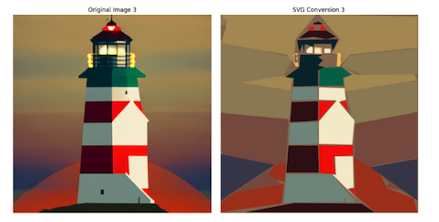

### Credits to jiazhuang (Zhuang Jia) and richolson (Richard Olson)

In [1]:
#| default_exp core

In [2]:
#| export

import kagglehub

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

metric = kagglehub.package_import('jiazhuang/svg-image-fidelity')

Installing python dependencies for Package 'kagglehub_package_jiazhuang_svg_image_fidelity_12', logging progress to '/tmp/kagglehub-package-dependencies-install-cdnz7ylf.txt'.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Competition Metric Helpers

We also want to evaluate metrics of the original bitmap before converting to svg. Let’s implement it using [metric package](https://www.kaggle.com/code/jiazhuang/svg-image-fidelity).

In [ ]:
import numpy as np
import statistics
import pandas as pd

def image_resize(image, size=(384, 384)):
    return image.convert('RGB').resize(size)

def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=42):
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = metric.ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    image = image_processor.image.copy()
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    vqa_score = metric.vqa_evaluator.score(questions, choices, answers, image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
    return instance_score, vqa_score, ocr_score, aesthetic_score

def bitmap_score_instance(multiple_choice_qa, image, random_seed=42):
    is_single = not isinstance(image, list)
    if is_single:
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]
    
    assert len(multiple_choice_qa) == len(image)

    results = []
    score_df = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(one_multiple_choice_qa, one_image, random_seed=42)
        results.append(instance_score)
        score_df.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results)
    score_df = pd.DataFrame(score_df, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    if is_single:
        return score_df.iloc[0].to_dict()
    else:
        return float(fidelity), score_df

In [ ]:
#| export

import random
import re
from colorsys import rgb_to_hls, hls_to_rgb

# Added from richolson/let-s-defeat-ocr-easy-lb-boost notebook
def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.
    
    Parameters:
    -----------
    svg_code : str
        The original SVG string
    
    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    modified_svg = svg_code
    try:
        # Check if SVG has a closing tag
        if "</svg>" not in svg_code:
            return svg_code
        
        # Extract viewBox if it exists to understand the dimensions
        viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
        if viewbox_match:
            viewbox = viewbox_match.group(1).split()
            try:
                x, y, width, height = map(float, viewbox)
            except ValueError:
                # Default dimensions if we can't parse viewBox
                width, height = 384, 384
        else:
            # Default dimensions if viewBox not found
            width, height = 384, 384
        
        # Function to convert hex color to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            if len(hex_color) == 3:
                hex_color = ''.join([c*2 for c in hex_color])
            return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
        
        # Function to convert RGB to hex
        def rgb_to_hex(rgb):
            return '#{:02x}{:02x}{:02x}'.format(
                int(rgb[0] * 255), 
                int(rgb[1] * 255), 
                int(rgb[2] * 255)
            )
        
        # Function to calculate color lightness
        def get_lightness(color):
            # Handle different color formats
            if color.startswith('#'):
                rgb = hex_to_rgb(color)
                return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
            elif color.startswith('rgb'):
                rgb_match = re.search(r'rgb\((\d+),\s*(\d+),\s*(\d+)\)', color)
                if rgb_match:
                    r, g, b = map(lambda x: int(x)/255, rgb_match.groups())
                    return rgb_to_hls(r, g, b)[1]
            return 0.5  # Default lightness if we can't parse
        
        # Extract all colors from the SVG
        color_matches = re.findall(r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code)
        
        # Default colors in case we don't find enough
        second_darkest_color = "#333333"  # Default to dark gray
        second_brightest_color = "#CCCCCC"  # Default to light gray
        
        if color_matches:
            # Remove duplicates and get unique colors
            unique_colors = list(set(color_matches))
            
            # Calculate lightness for each unique color
            colors_with_lightness = [(color, get_lightness(color)) for color in unique_colors]
            
            # Sort by lightness (brightness)
            sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])
            
            # Handle different scenarios based on number of unique colors
            if len(sorted_colors) >= 4:
                # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[-2][0]
            elif len(sorted_colors) == 3:
                # We have 3 unique colors - use 2nd darkest and brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[2][0]
            elif len(sorted_colors) == 2:
                # We have only 2 unique colors - use the darkest and brightest
                second_darkest_color = sorted_colors[0][0]
                second_brightest_color = sorted_colors[1][0]
            elif len(sorted_colors) == 1:
                # Only one color - use it for second_darkest and a derived lighter version
                base_color = sorted_colors[0][0]
                base_lightness = sorted_colors[0][1]
                second_darkest_color = base_color
                
                # Create a lighter color variant if the base is dark, or darker if base is light
                if base_lightness < 0.5:
                    # Base is dark, create lighter variant
                    second_brightest_color = "#CCCCCC"
                else:
                    # Base is light, create darker variant
                    second_darkest_color = "#333333"
        
        # Ensure the colors are different
        if second_darkest_color == second_brightest_color:
            # If they ended up the same, modify one of them
            if get_lightness(second_darkest_color) < 0.5:
                # It's a dark color, make the bright one lighter
                second_brightest_color = "#CCCCCC"
            else:
                # It's a light color, make the dark one darker
                second_darkest_color = "#333333"
        
        # Base size for the outer circle
        base_outer_radius = width * 0.023
        
        # Randomize size by ±10%
        size_variation = base_outer_radius * 0.1
        outer_radius = base_outer_radius + random.uniform(-size_variation, size_variation)
        
        # Define radii for inner circles based on outer radius
        middle_radius = outer_radius * 0.80
        inner_radius = middle_radius * 0.65
        
        # Calculate the maximum crop margin based on the image processing (5% of dimensions)
        # Add 20% extra margin for safety
        crop_margin_w = int(width * 0.05 * 1.2)
        crop_margin_h = int(height * 0.05 * 1.2)
        
        # Calculate center point based on the outer radius to ensure the entire circle stays visible
        safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)
        
        # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
        corner = random.randint(0, 3)
        
        # Position the circle in the chosen corner, accounting for crop margin
        if corner == 0:  # Top-left
            center_x = safe_offset
            center_y = safe_offset
        elif corner == 1:  # Top-right
            center_x = width - safe_offset
            center_y = safe_offset
        elif corner == 2:  # Bottom-left
            center_x = safe_offset
            center_y = height - safe_offset
        else:  # Bottom-right
            center_x = width - safe_offset
            center_y = height - safe_offset
        
        # Add a small random offset (±10% of safe_offset) to make positioning less predictable
        random_offset = safe_offset * 0.1
        center_x += random.uniform(-random_offset, random_offset)
        center_y += random.uniform(-random_offset, random_offset)
        
        # Round to 1 decimal place to keep file size down
        outer_radius = round(outer_radius, 1)
        middle_radius = round(middle_radius, 1)
        inner_radius = round(inner_radius, 1)
        center_x = round(center_x, 1)
        center_y = round(center_y, 1)
        
        # Create the nested circles
        outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
        middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
        inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'
        
        # Create a group element that contains all three circles
        group_element = f'<g>{outer_circle}{middle_circle}{inner_circle}</g>'
        
        # Insert the group element just before the closing SVG tag
        modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")
        
        # Calculate and add a comment with the byte size information
        outer_bytes = len(outer_circle.encode('utf-8'))
        middle_bytes = len(middle_circle.encode('utf-8'))
        inner_bytes = len(inner_circle.encode('utf-8'))
        total_bytes = outer_bytes + middle_bytes + inner_bytes
        
        corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
        byte_info = f'<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, ' \
                    f'inner={inner_bytes}, total={total_bytes}, ' \
                    f'colors: dark={second_darkest_color}, light={second_brightest_color}, ' \
                    f'position: {corner_names[corner]} -->'
        
        modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")
    except Exception as e:
        print(e)
    return modified_svg

## Load Stable Diffusion

In [ ]:
#| export

# Ensure GPU is being used and optimize for speed
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Load with optimized scheduler and half precision
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,  # Use half precision
    safety_checker=None         # Disable safety checker for speed
)

# Move to GPU and apply optimizations
pipe.to(device) 

## Load Data

In [ ]:
import pandas as pd
import json

In [ ]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [ ]:
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa')

train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))

train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps(
        [x.tolist() for x in qa['choices']], ensure_ascii=False
    )
)

train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

train_df = pd.merge(train_df, train_question_df, how='left', on='id')

train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
    'question': json.loads(r.question),
    'choices': json.loads(r.choices),
    'answer': json.loads(r.answer)
    },
    axis=1,
)

train_df.head()

## Bitmap Generation
* Inference steps (more for better quality / slower)
* Guidance scale (how tightly to follow prompts)

In [ ]:
#| export

def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15):
        
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps, 
        guidance_scale=guidance_scale,
    ).images[0]
    
    return image

In [ ]:
prompt_prefix = "Simple, classic image of"
prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"

In [ ]:
r = train_df.iloc[2]
description = r.description
print(description)

In [ ]:
prompt = f'{prompt_prefix} {description} {prompt_suffix}'
print(prompt)

In [ ]:
image = generate_bitmap(prompt, negative_prompt=negative_prompt)
image

In [ ]:
bitmap_score_instance(r.multiple_choice_qa, image, random_seed=42)

# Image -> SVG

* Did a bunch of work here trying to get good results..

In [ ]:
#| export

def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=16):
    """
    Extract image features hierarchically by scale
    
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
    
    Returns:
        list: Hierarchical features sorted by importance
    """
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
    
    # Hierarchical feature extraction
    hierarchical_features = []
    
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
    
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
    
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
        
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
        
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
            
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
            
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
            
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
            
            # Simplify contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
            
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
            
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance,
                'point_count': len(approx),
                'original_contour': approx  # Store original contour for adaptive simplification
            })
        
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
    
    return hierarchical_features

def simplify_polygon(points_str, simplification_level):
    """
    Simplify a polygon by reducing coordinate precision or number of points
    
    Args:
        points_str (str): Space-separated "x,y" coordinates
        simplification_level (int): Level of simplification (0-3)
    
    Returns:
        str: Simplified points string
    """
    if simplification_level == 0:
        return points_str
    
    points = points_str.split()
    
    # Level 1: Round to 1 decimal place
    if simplification_level == 1:
        return " ".join([f"{float(p.split(',')[0]):.1f},{float(p.split(',')[1]):.1f}" for p in points])
    
    # Level 2: Round to integer
    if simplification_level == 2:
        return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
    
    # Level 3: Reduce number of points (keep every other point, but ensure at least 3 points)
    if simplification_level == 3:
        if len(points) <= 4:
            # If 4 or fewer points, just round to integer
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in points])
        else:
            # Keep approximately half the points, but maintain at least 3
            step = min(2, len(points) // 3)
            reduced_points = [points[i] for i in range(0, len(points), step)]
            # Ensure we keep at least 3 points and the last point
            if len(reduced_points) < 3:
                reduced_points = points[:3]
            if points[-1] not in reduced_points:
                reduced_points.append(points[-1])
            return " ".join([f"{float(p.split(',')[0]):.0f},{float(p.split(',')[1]):.0f}" for p in reduced_points])
    
    return points_str

def bitmap_to_svg_layered(image, max_size_bytes=10000, resize=True, target_size=(384, 384), 
                         adaptive_fill=True, num_colors=None):
    """
    Convert bitmap to SVG using layered feature extraction with optimized space usage
    
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
        adaptive_fill (bool): Whether to adaptively fill available space
        num_colors (int): Number of colors to quantize, if None uses adaptive selection
    
    Returns:
        str: SVG representation
    """
    # Adaptive color selection based on image complexity
    if num_colors is None:
        # Simple heuristic: more colors for complex images
        if resize:
            pixel_count = target_size[0] * target_size[1]
        else:
            pixel_count = image.size[0] * image.size[1]
        
        if pixel_count < 65536:  # 256x256
            num_colors = 8
        elif pixel_count < 262144:  # 512x512
            num_colors = 12
        else:
            num_colors = 16
    
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
    
    # Convert to numpy array
    img_np = np.array(image)
    
    # Get image dimensions
    height, width = img_np.shape[:2]
    
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
    
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg_header = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">\n'
    svg_bg = f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>\n'
    svg_base = svg_header + svg_bg
    svg_footer = '</svg>'
    
    # Calculate base size
    base_size = len((svg_base + svg_footer).encode('utf-8'))
    available_bytes = max_size_bytes - base_size
    
    # Extract hierarchical features
    features = extract_features_by_scale(img_np, num_colors=num_colors)
    
    # If not using adaptive fill, just add features until we hit the limit
    if not adaptive_fill:
        svg = svg_base
        for feature in features:
            # Try adding the feature
            feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
            
            # Check if adding this feature exceeds size limit
            if len((svg + feature_svg + svg_footer).encode('utf-8')) > max_size_bytes:
                break
            
            # Add the feature
            svg += feature_svg
        
        # Close SVG
        svg += svg_footer
        return svg
    
    # For adaptive fill, use binary search to find optimal simplification level
    
    # First attempt: calculate size of all features at different simplification levels
    feature_sizes = []
    for feature in features:
        feature_sizes.append({
            'original': len(f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level1': len(f'<polygon points="{simplify_polygon(feature["points"], 1)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level2': len(f'<polygon points="{simplify_polygon(feature["points"], 2)}" fill="{feature["color"]}" />\n'.encode('utf-8')),
            'level3': len(f'<polygon points="{simplify_polygon(feature["points"], 3)}" fill="{feature["color"]}" />\n'.encode('utf-8'))
        })
    
    # Two-pass approach: first add most important features, then fill remaining space
    svg = svg_base
    bytes_used = base_size
    added_features = set()
    
    # Pass 1: Add most important features at original quality
    for i, feature in enumerate(features):
        feature_svg = f'<polygon points="{feature["points"]}" fill="{feature["color"]}" />\n'
        feature_size = feature_sizes[i]['original']
        
        if bytes_used + feature_size <= max_size_bytes:
            svg += feature_svg
            bytes_used += feature_size
            added_features.add(i)
    
    # Pass 2: Try to add remaining features with progressive simplification
    for level in range(1, 4):  # Try simplification levels 1-3
        for i, feature in enumerate(features):
            if i in added_features:
                continue
                
            feature_size = feature_sizes[i][f'level{level}']
            if bytes_used + feature_size <= max_size_bytes:
                feature_svg = f'<polygon points="{simplify_polygon(feature["points"], level)}" fill="{feature["color"]}" />\n'
                svg += feature_svg
                bytes_used += feature_size
                added_features.add(i)
    
    # Finalize SVG
    svg += svg_footer
    
    # Double check we didn't exceed limit
    final_size = len(svg.encode('utf-8'))
    if final_size > max_size_bytes:
        # If we somehow went over, return basic SVG
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
    
    # Calculate space utilization
    utilization = (final_size / max_size_bytes) * 100
    
    # Return the SVG with efficient space utilization
    return svg

In [ ]:
from IPython.display import SVG

In [ ]:
svg_content = bitmap_to_svg_layered(image)
SVG(svg_content)

In [ ]:
%%time
metric.score_instance(r.multiple_choice_qa, svg_content, random_seed=42)

In [ ]:
#| export
def get_vqa_aes_and_ocr_score(svg_content, questions_template, prompt):
    svg_to_png_converted = metric.svg_to_png(svg_content)
    image_processor = metric.ImageProcessor(image=svg_to_png_converted, seed=33).apply()
    image = image_processor.image.copy()

    p_fidelity = metric.vqa_evaluator.score_yes_no(questions_template['fidelity'].format(prompt), image)
    vqa_score = p_fidelity

    # aesthetic_score = metric.aesthetic_evaluator.score(image)
    aesthetic_score = 1
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)

    return vqa_score, aesthetic_score, ocr_score

## Implement the package Model class

In [ ]:
#| export

class Model:
    def __init__(self):
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.prompt_prefix = "Simple, classic image of"
        self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
        # self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"

        self.prompt_templates = [
            "Stylized representation of {description} using clean shapes and no background elements",
            "Simple, classic image of {description} with flat colors, beautiful, minimal details",
            "Simple, classic, aesthetic representation of {description} using clean shapes and no background elements"        
        ]
        self.negative_prompt = "framing, hatching, background, details"
        self.questions_template = {
                'fidelity': 'Does <image> portray "SVG illustration of {}"? Answer yes or no.'                
        }
        self.num_inference_steps = 25
        self.guidance_scale = 20
        self.num_attempt = 3

    def gen_bitmap(self, prompt):
        # prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
        bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale)
        return bitmap

    def predict_impl(self, description: str) -> str:
        best_score = 0.0
        best_svg = None        
        best_img = None
        
        for i in range(self.num_attempt):
            prompt_template = self.prompt_templates[i]
            prompt = prompt_template.format(description=description)
            bitmap = self.gen_bitmap(prompt)
            svg = bitmap_to_svg_layered(bitmap, max_size_bytes=9650)
            svg = add_ocr_decoy_svg(svg)
            vqa_score, aesthetic_score, ocr_score = get_vqa_aes_and_ocr_score(svg, self.questions_template, description)
            score = vqa_score * ocr_score
            # score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            
            if score >= best_score:
                best_score = score
                best_svg = svg
                best_img = bitmap
                print('update score:', best_score)
        
        if best_svg is None:
            best_svg = self.default_svg

        return best_svg, best_img

    def predict(self, prompt: str) -> str:
        svg, img = self.predict_impl(prompt)
        return svg

In [ ]:
model = Model()

In [ ]:
%%time
svg = model.predict(description)
SVG(svg)

In [ ]:
metric.score_instance(r.multiple_choice_qa, svg, random_seed=42)

## Evaluate on train dataset (LB prediction!)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
# train_df = train_df[:3]

In [ ]:
train_df.head()

In [ ]:
%%time
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

In [ ]:
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

In [ ]:
train_df['bitmap_score'] = train_df.progress_apply(
    lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=42),
    axis=1,
)

In [ ]:
train_df['svg_score'] = train_df.progress_apply(
    lambda r: metric.score_instance(r.multiple_choice_qa, r.svg, random_seed=42),
    axis=1,
)

In [ ]:
for r in train_df.itertuples():
    b_score = r.bitmap_score['competition_score']
    b_vqa = r.bitmap_score['vqa_score']
    b_ocr = r.bitmap_score['ocr_score']
    b_aesthetic = r.bitmap_score['aesthetic_score']

    s_score = r.svg_score['competition_score']
    s_vqa = r.svg_score['vqa_score']
    s_ocr = r.svg_score['ocr_score']
    s_aesthetic = r.svg_score['aesthetic_score']
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(r.description, y=0.93)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(r.bitmap))
    plt.axis('off')
    plt.title(f'bitmap: score={b_score:.2f}, vqa={b_vqa:.2f}, ocr={b_ocr:.2f}, aes={b_aesthetic:.2f}')

    plt.subplot(1, 2, 2)
    plt.imshow(metric.svg_to_png(r.svg))
    plt.axis('off')
    plt.title(f'svg: score={s_score:.2f}, vqa={s_vqa:.2f}, ocr={s_ocr:.2f}, aes={s_aesthetic:.2f}')

In [ ]:
mean_bitmap_score = pd.DataFrame(train_df['bitmap_score'].tolist()).mean(axis=0)
mean_bitmap_score

In [ ]:
mean_svg_score = pd.DataFrame(train_df['svg_score'].tolist()).mean(axis=0)
mean_svg_score

In [ ]:
print(f'Original bitmap score: {mean_bitmap_score.competition_score}')
print(f'Final svg score: {mean_svg_score.competition_score}')